<div style="color:white;
            display:fill;
            border-radius:5px;
            background: rgb(182,213,183);
            background-image: linear-gradient(275deg, rgba(182,213,183,1) 25%, rgba(165,165,200,1) 75%);
            font-size:110%;
            font-family:Verdana;
            letter-spacing:0.5px">
    <h1 style="padding: 10px;
              color:white;">The use of Machine Learning to predict 68Ga-PSMA-11 PET/CT result in different clinical settings of biochemical relapse after radical treatment for prostate cancer: comparison with a published nomogram.</h1>
</div>

<h2 style="
              color:black;">Libraries and Functions declaration</h2>

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, log_loss, roc_auc_score, roc_curve, auc
from sklearn.linear_model import LogisticRegression

from scipy.stats import ks_2samp, ttest_ind

import pycaret
from pycaret.classification import *
from pycaret.classification import ClassificationExperiment

import pyroc
from joblib import dump, load

In [2]:
def roc_auc(y_test, y_pred, pos_label = 1):

    fpr, tpr, thresholds = roc_curve(y_test, y_pred)

    # AUC score that summarizes the ROC curve
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, lw = 2, label = 'ROC AUC: {:.2f}'.format(roc_auc))
    plt.plot([0, 1], [0, 1],
             linestyle = '--',
             color = (0.6, 0.6, 0.6),
             label = 'random guessing')
    plt.plot([0, 0, 1], [0, 1, 1],
             linestyle = ':',
             color = 'black', 
             label = 'perfect performance')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
    plt.title('Receiver Operator Characteristic')
    plt.legend(loc = "lower right")
    plt.tight_layout()
    plt.show()

In [3]:
def Find_Optimal_Cutoff(target, predicted):
    df = pd.DataFrame(target.values, columns=['y'])
    df['pred'] = predicted
    
    cutoff = []
    acc = []
    for co in np.arange(0, 100.1, 0.1):

        TP = df[(df.pred>=co/100)&(df.y==1)].index.size
        FP = df[(df.pred>=co/100)&(df.y==0)].index.size
        TN = df[(df.pred< co/100)&(df.y==0)].index.size
        FN = df[(df.pred< co/100)&(df.y==1)].index.size

        cutoff.append(co)
        acc.append((TN + TP)/(TN+TP+FN+FP))

    cut_off = pd.DataFrame(cutoff, columns=['Cut_Off'])
    cut_off['Accuracy'] = acc

    print(cut_off[cut_off['Accuracy'] == max(cut_off['Accuracy'])])

In [4]:
def Kolomogorov_Smirnov_splitting(in_df, in_n_tries, in_y, in_test_size):

    n_features = in_df.drop(in_y, axis = 1).shape[1]

    result = []

    for random_state in range(in_n_tries):
        X_learning, X_test, y_learning, y_test = train_test_split(in_df.drop(in_y,axis = 1), in_df[in_y],random_state=random_state, test_size=in_test_size, stratify=in_df[in_y])

        distances = list(map(lambda i : ks_2samp(X_learning.iloc[:,i],X_test.iloc[:,i]).statistic,range(n_features)))
        result.append((random_state,max(distances)))

    result.sort(key = lambda x : x[1])

    X_learning, X_test, y_learning, y_test = train_test_split(in_df.drop(in_y,axis = 1), in_df[in_y],random_state=result[0][0], test_size=in_test_size, stratify=in_df[in_y])
    
    return X_learning, X_test, y_learning, y_test

<h2 style="
              color:black;">Preprocessing</h2>

In [5]:
df = pd.read_csv('db703.csv', decimal=',')
for col in df.columns:
    if df[col].isna().sum() > 0:
        df.drop(col, axis=1, inplace= True)
        
df['DATE Treatment'] = pd.to_datetime(df['DATE Treatment'], format='%d/%m/%Y', errors='coerce')
df['DATE PSMA'] = pd.to_datetime(df['DATE PSMA'], format='%d/%m/%Y', errors='coerce')
df['diff_days'] = (df['DATE PSMA'] - df['DATE Treatment']) / np.timedelta64(1, 'D')
df['Clinical Stage of BCR'].replace({1:3, 2:1, 3:2}, inplace=True)
df['Clinical Stage of BCR'].replace({1:0, 2:1, 3:2, 4:3}, inplace=True)
df['ISUP Group'].replace({1:0, 2:1, 3:2, 4:3, 5:4}, inplace=True)

nomogram_features = ['ISUP Group','On-going ADT at BCR', 'Time To BCR (months)', 'PSA at PSMA PET (ng/mL)', 'PSA doubling time', 'Clinical Stage of BCR', 'PET RESULT']

<h2 style="
              color:black;">EDA</h2>

In [6]:
features_columns_nodates = ['GS Sum', 'ISUP Group', 'Radical Tp', 'Pelvic LND',
       'Adjuvant Radiotherapy', 'Adjuvant ADT', 'ADT during BCR', 'Salvage therapies (yes/no)', 'Radiotherapy Salvage Therapy', 'Lymphadenectomy Salvage Therapy', 'Other Salvage Therapies', 'On-going ADT at BCR',
       'Time To BCR (months)', 'PSA at PSMA PET (ng/mL)', 'PSA doubling time',
       'PSAVel (ng/mL/yr)', 'Clinical Stage of BCR', 'PET RESULT']

In [7]:
df[features_columns_nodates].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 703 entries, 0 to 702
Data columns (total 18 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   GS Sum                           703 non-null    int64  
 1   ISUP Group                       703 non-null    int64  
 2   Radical Tp                       703 non-null    int64  
 3   Pelvic LND                       703 non-null    int64  
 4   Adjuvant Radiotherapy            703 non-null    int64  
 5   Adjuvant ADT                     703 non-null    int64  
 6   ADT during BCR                   703 non-null    int64  
 7   Salvage therapies (yes/no)       703 non-null    int64  
 8   Radiotherapy Salvage Therapy     703 non-null    int64  
 9   Lymphadenectomy Salvage Therapy  703 non-null    int64  
 10  Other Salvage Therapies          703 non-null    int64  
 11  On-going ADT at BCR              703 non-null    int64  
 12  Time To BCR (months)  

In [8]:
df[features_columns_nodates].describe().T

,count,mean,std,min,25%,50%,75%,max
GS Sum,703.0,7.479374,0.884700,6.00,7.000,7.00,8.00,10.0
ISUP Group,703.0,2.044097,1.063264,0.00,1.000,2.00,3.00,4.0
Radical Tp,703.0,0.027027,0.162278,0.00,0.000,0.00,0.00,1.0
Pelvic LND,703.0,0.762447,0.425887,0.00,1.000,1.00,1.00,1.0
Adjuvant Radiotherapy,703.0,0.258890,0.438337,0.00,0.000,0.00,1.00,1.0
Adjuvant ADT,703.0,0.179232,0.383819,0.00,0.000,0.00,0.00,1.0
ADT during BCR,703.0,0.294452,0.456121,0.00,0.000,0.00,1.00,1.0
Salvage therapies (yes/no),703.0,0.731152,0.443676,0.00,0.000,1.00,1.00,1.0
Radiotherapy Salvage Therapy,703.0,0.241821,0.428491,0.00,0.000,0.00,0.00,1.0
Lymphadenectomy Salvage Therapy,703.0,0.019915,0.139807,0.00,0.000,0.00,0.00,1.0


In [9]:
df.duplicated().sum()

0

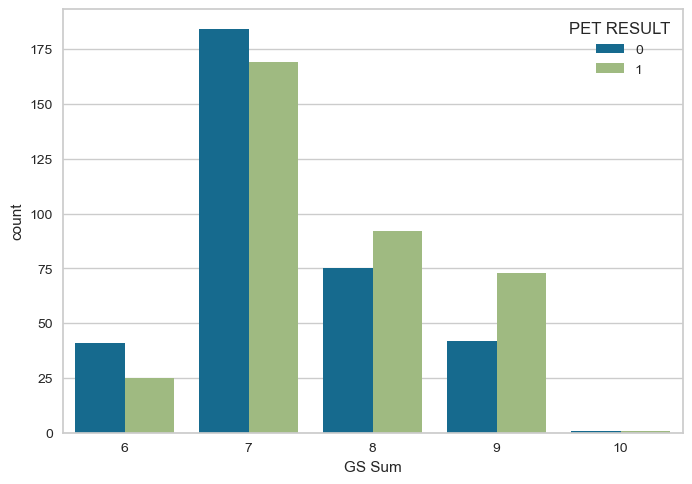

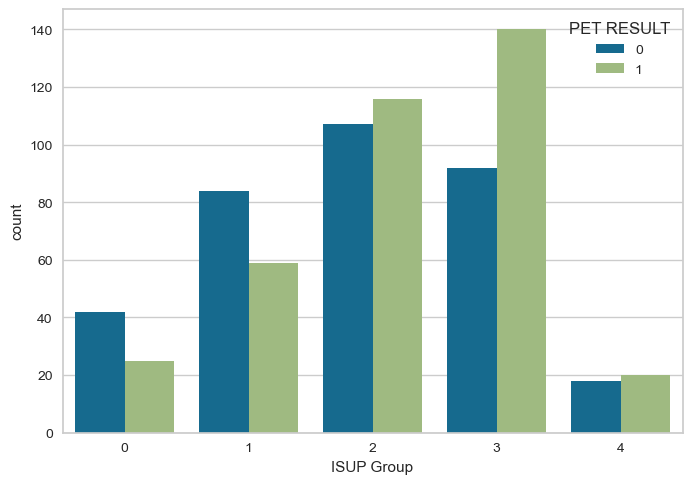

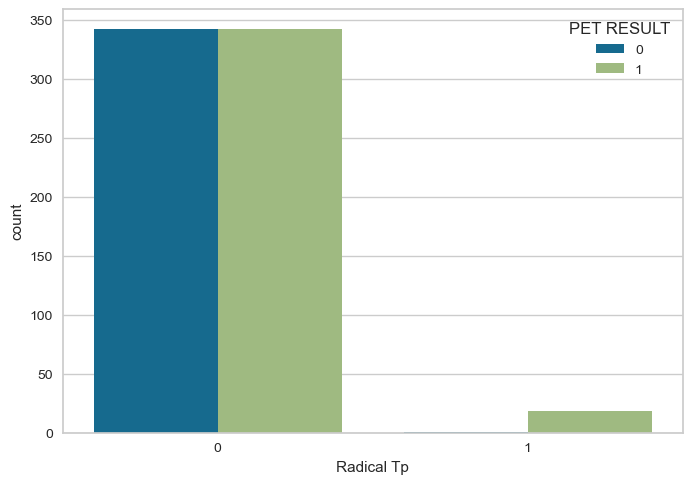

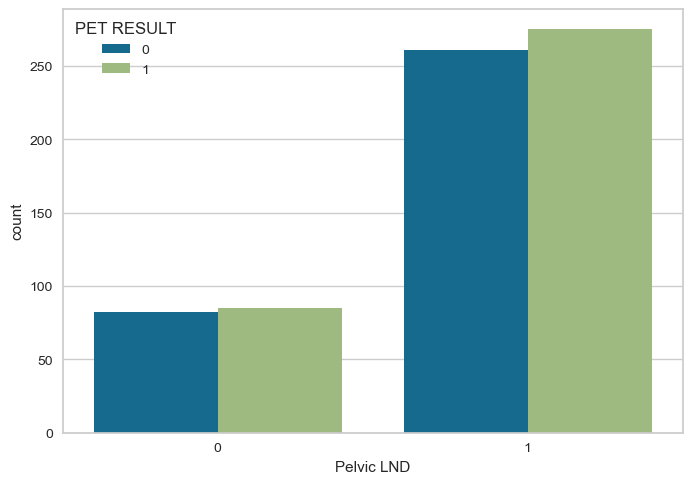

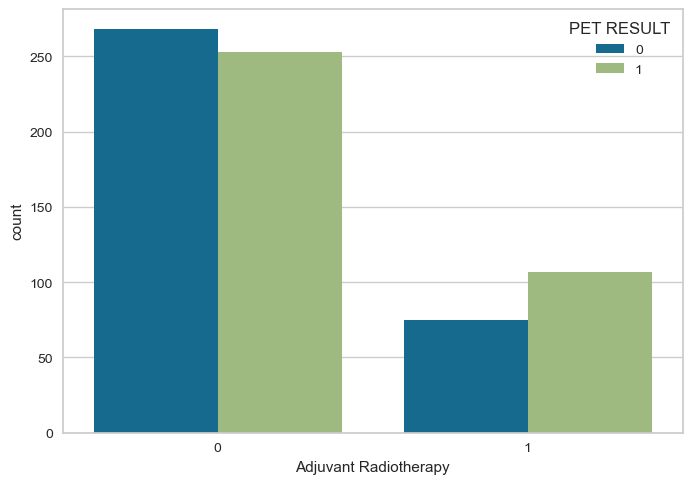

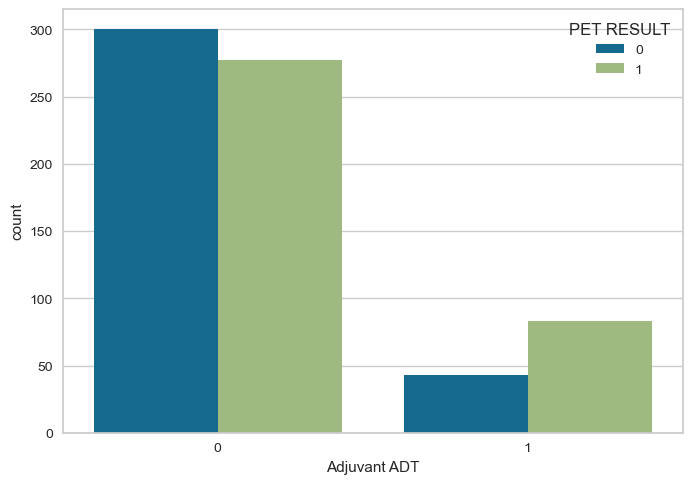

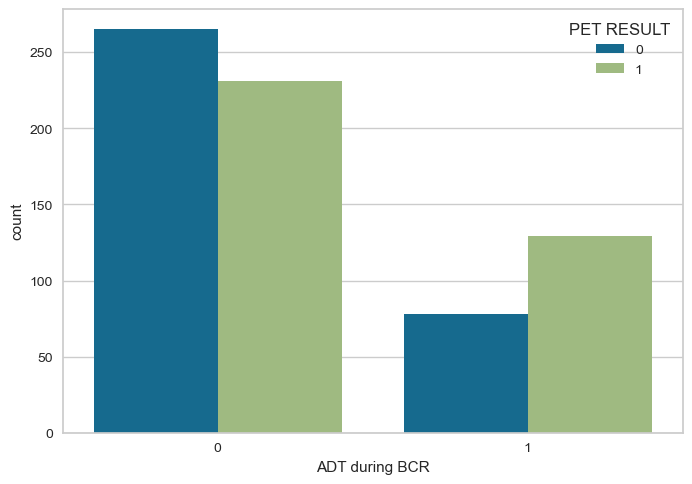

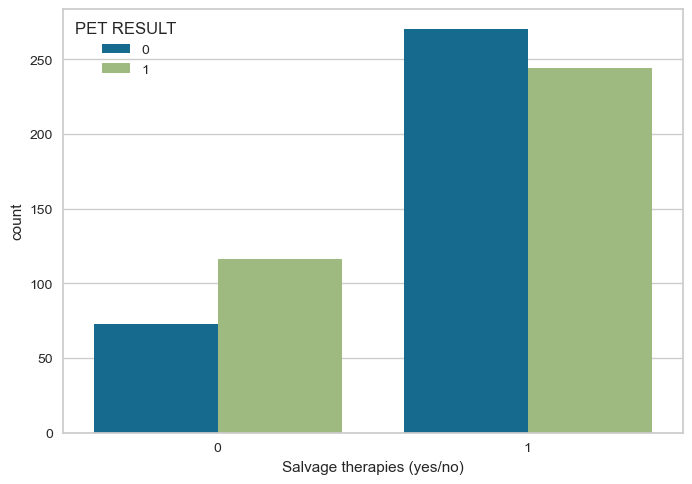

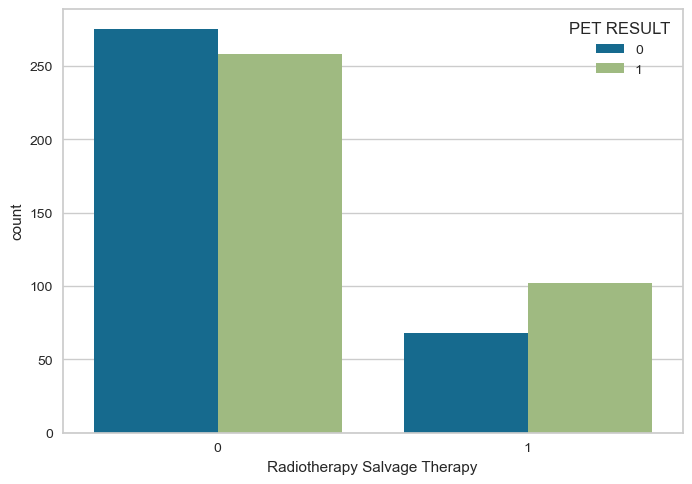

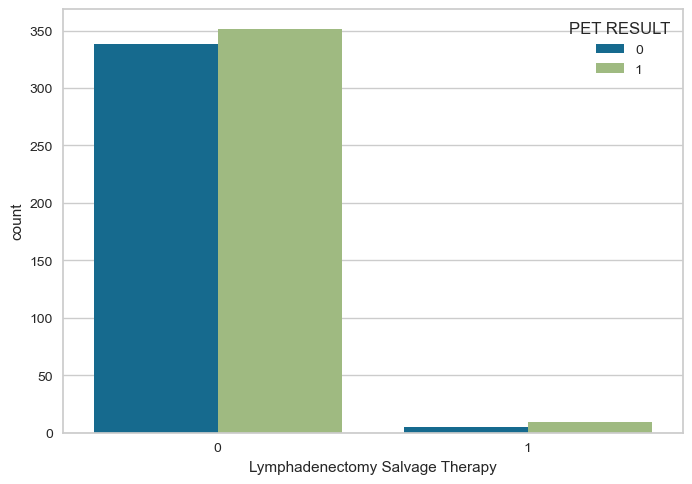

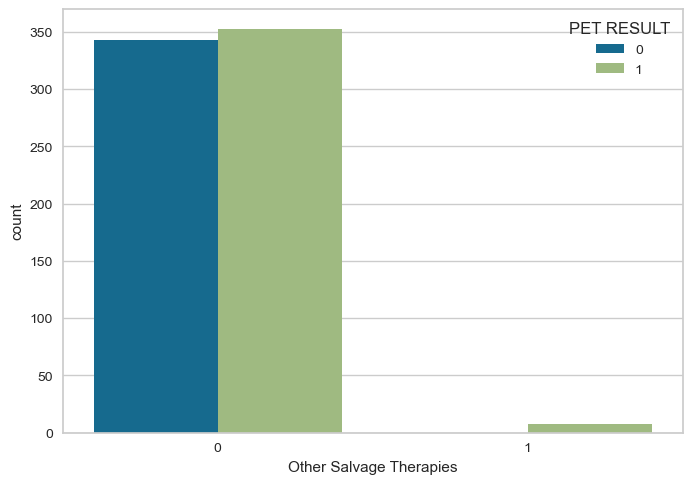

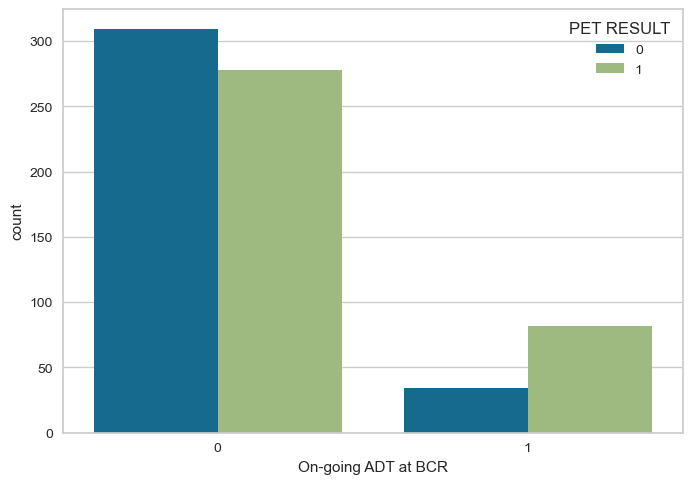

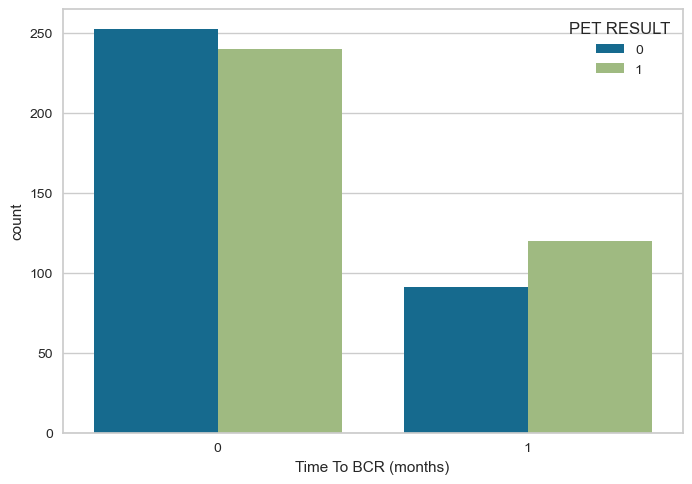

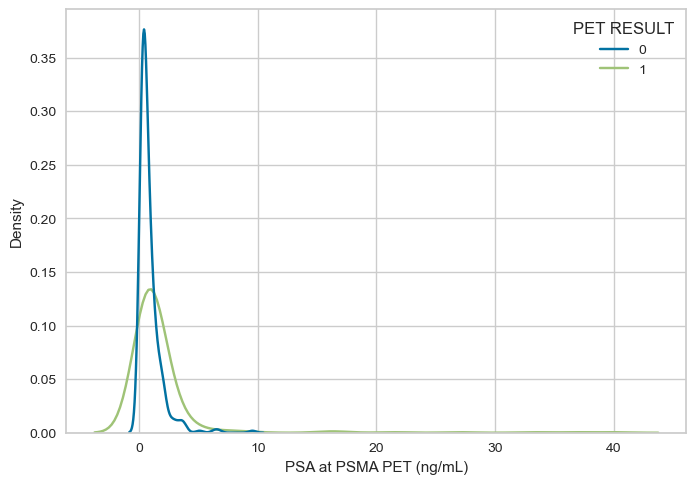

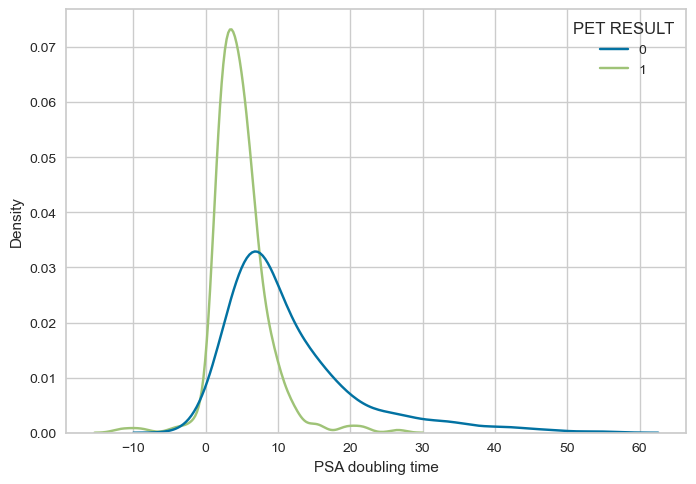

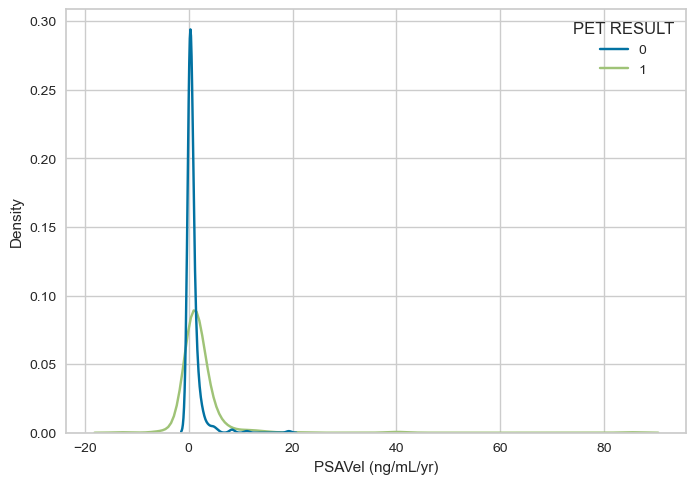

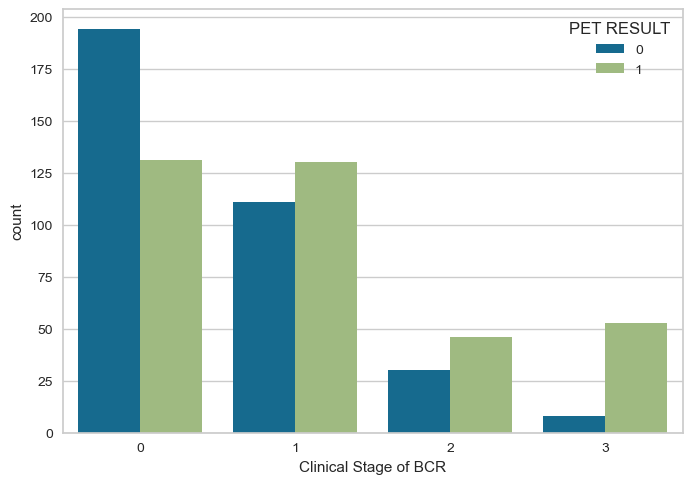

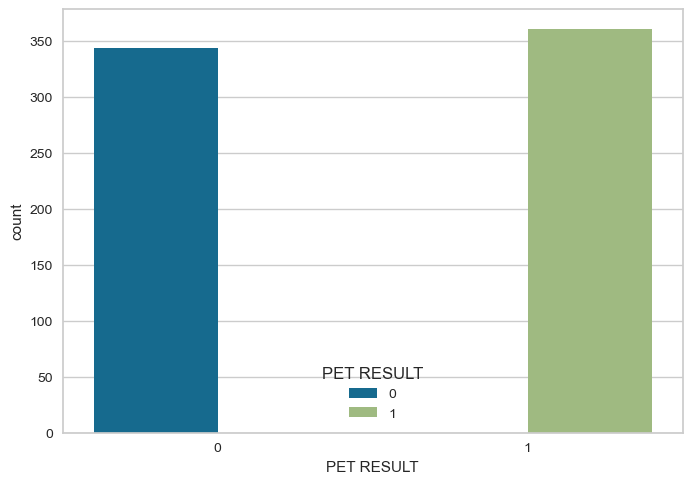

In [10]:
for feat in features_columns_nodates:
    if len(set(df[feat])) < 6:
        plt.figure()
        sns.countplot(data = df, x=feat, hue = 'PET RESULT')
    else:
        plt.figure()
        sns.kdeplot(data = df, x=feat, hue = 'PET RESULT')

<Axes: >

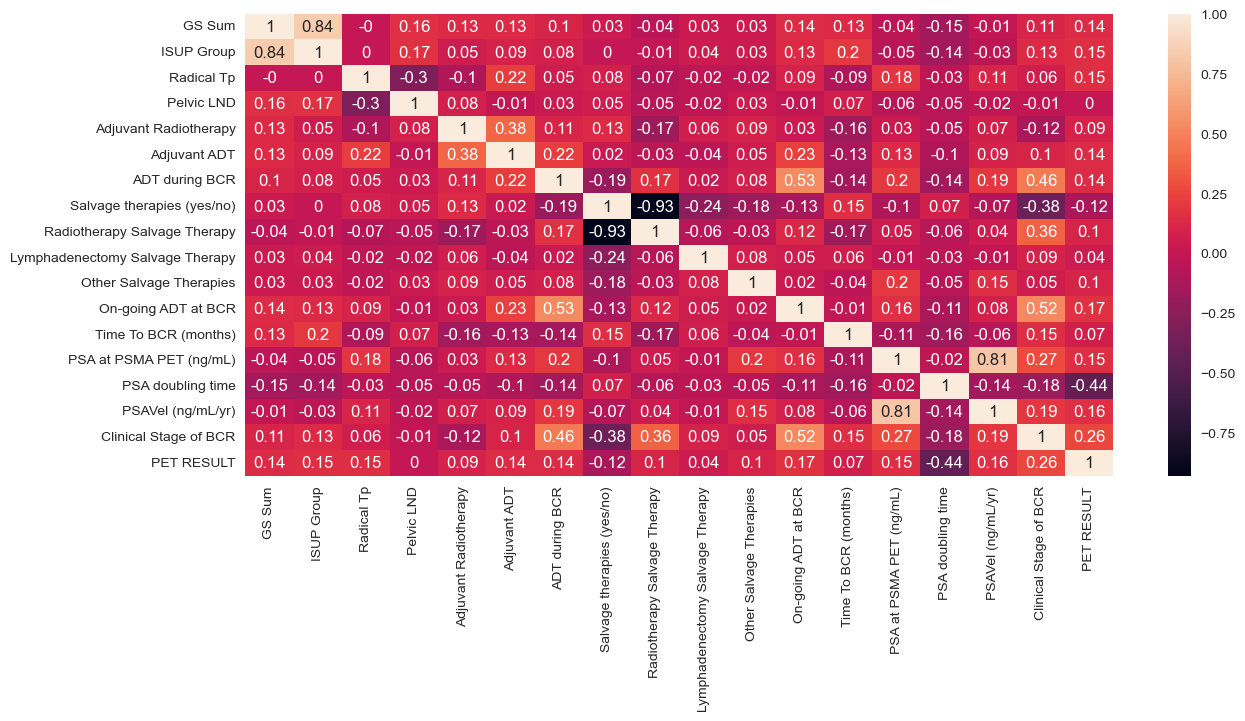

In [11]:
plt.figure(figsize=(14, 6))
sns.heatmap(round(df[features_columns_nodates].corr(),2), annot=True)

**EDA Conclusions:**

Features removed:
- Radical Tp: excluded for bias numerosity
- GS Sum: correlation > 80% with *ISUP Group*
- Radiotherpy Salvage Therapy: correlation > 80% with *Salvage therapies (yes/no)*
- Lymphadenectomy Salvage Therapy: excluded for bias numerosity
- Other Salvage Therapies: excluded for bias numerosity
- PSAVel (ng/mL/yr): correlation > 80% with *PSA at PSMA PET (ng/mL)*

In [12]:
features_pruned = ['ISUP Group', 'Pelvic LND', 'Adjuvant Radiotherapy', 'Adjuvant ADT', 'ADT during BCR', 'Salvage therapies (yes/no)', 'On-going ADT at BCR',
       'Time To BCR (months)', 'PSA at PSMA PET (ng/mL)', 'PSA doubling time', 'Clinical Stage of BCR', 'PET RESULT']

<h2 style="
              color:black;">Features reduction</h2>
              
Logistic Regression with penalty = L1

In [13]:
# Train - Test splitting
X_learning_fp, X_test_fp, y_learning, y_test = Kolomogorov_Smirnov_splitting(in_df = df[features_pruned], in_n_tries = 1000, in_y = 'PET RESULT', in_test_size = 0.1)

In [14]:
# Finding optimal Cross Validation folds number

for ncv in range(2,11,1):

    lr = LogisticRegression(penalty='l1', random_state=123)

    search = GridSearchCV(lr,
                          {'C':np.arange(0.01,1,0.01),
                          'solver': ('liblinear', 'lbfgs',  'newton-cg', 'newton-cholesky', 'sag', 'saga')},
                          cv = ncv, scoring="roc_auc",verbose=0
                          )

    search.fit(X_learning_fp,y_learning)

    print(f'CV folds: {ncv} | {search.best_params_} | LogLoss: {log_loss(y_test, search.best_estimator_.predict_proba(X_test_fp))} | AUC: {roc_auc_score(y_test, search.best_estimator_.predict_proba(X_test_fp)[:,1])} ')

CV folds: 2 | {'C': 0.06999999999999999, 'solver': 'saga'} | LogLoss: 0.4855025739197877 | AUC: 0.8452380952380952 
CV folds: 3 | {'C': 0.08, 'solver': 'saga'} | LogLoss: 0.483829745948063 | AUC: 0.8468253968253969 
CV folds: 4 | {'C': 0.06999999999999999, 'solver': 'saga'} | LogLoss: 0.4855025739197877 | AUC: 0.8452380952380952 
CV folds: 5 | {'C': 0.08, 'solver': 'saga'} | LogLoss: 0.483829745948063 | AUC: 0.8468253968253969 
CV folds: 6 | {'C': 0.06999999999999999, 'solver': 'saga'} | LogLoss: 0.4855025739197877 | AUC: 0.8452380952380952 
CV folds: 7 | {'C': 0.06999999999999999, 'solver': 'saga'} | LogLoss: 0.4855025739197877 | AUC: 0.8452380952380952 
CV folds: 8 | {'C': 0.06999999999999999, 'solver': 'saga'} | LogLoss: 0.4855025739197877 | AUC: 0.8452380952380952 
CV folds: 9 | {'C': 0.06999999999999999, 'solver': 'saga'} | LogLoss: 0.4855025739197877 | AUC: 0.8452380952380952 
CV folds: 10 | {'C': 0.060000000000000005, 'solver': 'saga'} | LogLoss: 0.48779352088455963 | AUC: 0.842

In [15]:
# Retrain the model setting optimal folds number

lr = LogisticRegression(penalty='l1', random_state = 123)

ncv = 5

search = GridSearchCV(lr,
                      {'C':np.arange(0.01,1,0.01),
                      'solver': ('liblinear', 'lbfgs',  'newton-cg', 'newton-cholesky', 'sag', 'saga')},
                      cv = ncv, scoring="roc_auc",verbose=0
                      )

search.fit(X_learning_fp,y_learning)

print(f'CV folds: {ncv} | {search.best_params_} | LogLoss: {log_loss(y_test, search.best_estimator_.predict_proba(X_test_fp))} | AUC: {roc_auc_score(y_test, search.best_estimator_.predict_proba(X_test_fp)[:,1])} ')

CV folds: 5 | {'C': 0.08, 'solver': 'saga'} | LogLoss: 0.483829745948063 | AUC: 0.8468253968253969 


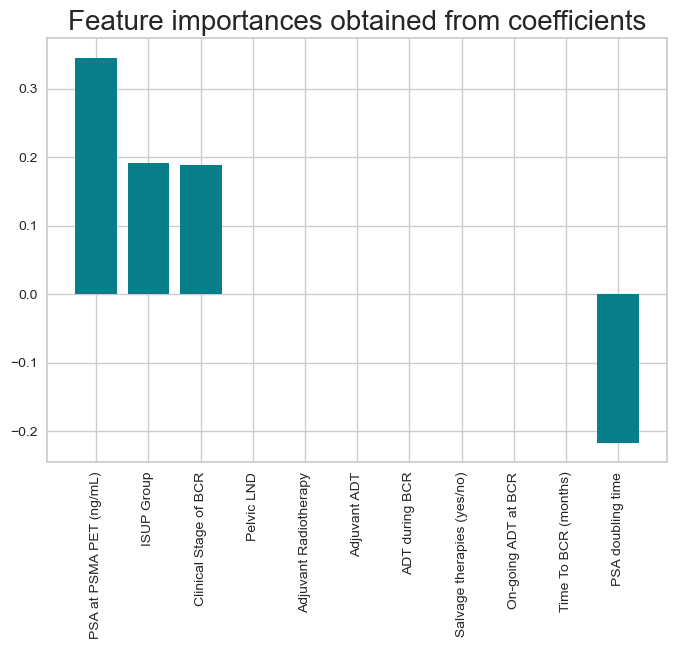

In [16]:
importances = pd.DataFrame(data={
    'Attribute': X_learning_fp.columns,
    'Importance': search.best_estimator_.coef_[0]
})
importances = importances.sort_values(by='Importance', ascending=False)

plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
plt.title('Feature importances obtained from coefficients', size=20)
plt.xticks(rotation='vertical')
plt.show()

In [17]:
importances.reset_index().drop(columns='index').round(decimals=2)

,Attribute,Importance
0,PSA at PSMA PET (ng/mL),0.35
1,ISUP Group,0.19
2,Clinical Stage of BCR,0.19
3,Pelvic LND,0.00
4,Adjuvant Radiotherapy,0.00
5,Adjuvant ADT,0.00
6,ADT during BCR,0.00
7,Salvage therapies (yes/no),0.00
8,On-going ADT at BCR,0.00
9,Time To BCR (months),0.00


In [18]:
# Select only the subset of features with importance different than 0

features_reduced = importances[importances['Importance'] != 0]['Attribute'].tolist()

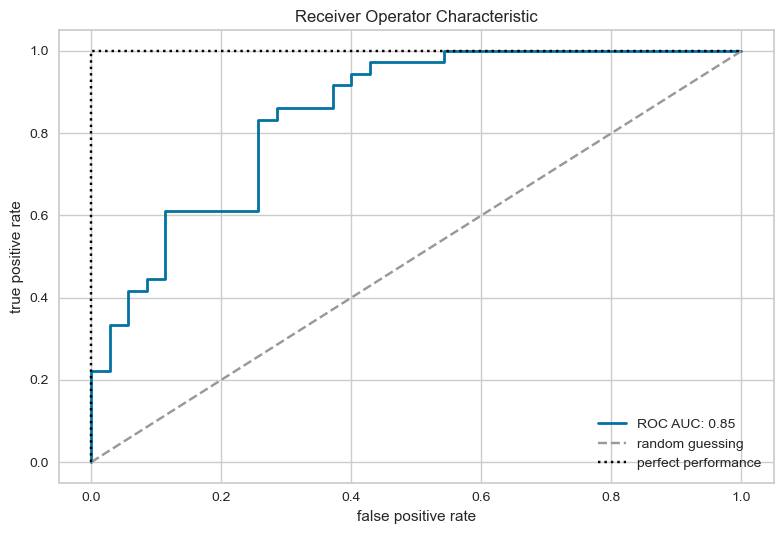

In [19]:
roc_auc(y_test, search.best_estimator_.predict_proba(X_test_fp)[:,1])

In [20]:
# Finding the best probability threshold to have the best accuracy

Find_Optimal_Cutoff(y_test, search.best_estimator_.predict_proba(X_test_fp)[:,1])

     Cut_Off  Accuracy
527     52.7  0.788732
535     53.5  0.788732
536     53.6  0.788732
537     53.7  0.788732
538     53.8  0.788732
539     53.9  0.788732


<h2 style="
              color:black;">Logistic Regression - Features Reduced</h2>

In [21]:
# Train - Test splitting

features_reduced.append('PET RESULT')
X_learning_redu, X_test_redu, _, _ = Kolomogorov_Smirnov_splitting(df[features_reduced], 1000, 'PET RESULT', 0.1)

In [22]:
# Finding optimal Cross Validation folds number

for ncv in range(2,11,1):
    lr = LogisticRegression(penalty = 'l1', random_state = 123)

    parameters = {'C':np.arange(0.01,1,0.01),  
                  'solver':('liblinear', 'lbfgs',  'newton-cg', 'newton-cholesky', 'sag', 'saga')}

    search = GridSearchCV(lr, parameters, cv = ncv, scoring="roc_auc",verbose=0)

    search.fit(X_learning_redu,y_learning)
    
    print(f'CV folds: {ncv} | {search.best_params_} | LogLoss: {log_loss(y_test, search.best_estimator_.predict_proba(X_test_redu))} | AUC: {roc_auc_score(y_test, search.best_estimator_.predict_proba(X_test_redu)[:,1])} ')

CV folds: 2 | {'C': 0.06999999999999999, 'solver': 'saga'} | LogLoss: 0.48551937136305484 | AUC: 0.8460317460317461 
CV folds: 3 | {'C': 0.08, 'solver': 'saga'} | LogLoss: 0.48385065271857897 | AUC: 0.8468253968253969 
CV folds: 4 | {'C': 0.06999999999999999, 'solver': 'saga'} | LogLoss: 0.48551937136305484 | AUC: 0.8460317460317461 
CV folds: 5 | {'C': 0.09, 'solver': 'saga'} | LogLoss: 0.4825821254203262 | AUC: 0.8468253968253969 
CV folds: 6 | {'C': 0.06999999999999999, 'solver': 'saga'} | LogLoss: 0.48551937136305484 | AUC: 0.8460317460317461 
CV folds: 7 | {'C': 0.12, 'solver': 'saga'} | LogLoss: 0.48012647155284 | AUC: 0.8468253968253968 
CV folds: 8 | {'C': 0.64, 'solver': 'liblinear'} | LogLoss: 0.4754320730034732 | AUC: 0.85 
CV folds: 9 | {'C': 0.060000000000000005, 'solver': 'saga'} | LogLoss: 0.48780730514455733 | AUC: 0.8420634920634921 
CV folds: 10 | {'C': 0.060000000000000005, 'solver': 'saga'} | LogLoss: 0.48780730514455733 | AUC: 0.8420634920634921 


In [23]:
# Retrain the model setting optimal folds number

lr = LogisticRegression(penalty = 'l1', random_state = 123)

ncv = 8

parameters = {'C':np.arange(0.01,1,0.01),  
              'solver':('liblinear', 'lbfgs',  'newton-cg', 'newton-cholesky', 'sag', 'saga')}

search = GridSearchCV(lr, parameters, cv = ncv, scoring="roc_auc",verbose=0)

search.fit(X_learning_redu,y_learning)

lr_reduced_model = search.best_estimator_

dump(lr_reduced_model, 'lr_reduced_model.sav')

print(f'CV folds: {ncv} | {search.best_params_} | LogLoss: {log_loss(y_test, lr_reduced_model.predict_proba(X_test_redu))} | AUC: {roc_auc_score(y_test, lr_reduced_model.predict_proba(X_test_redu)[:,1])} ')

CV folds: 8 | {'C': 0.64, 'solver': 'liblinear'} | LogLoss: 0.4754320730034732 | AUC: 0.85 


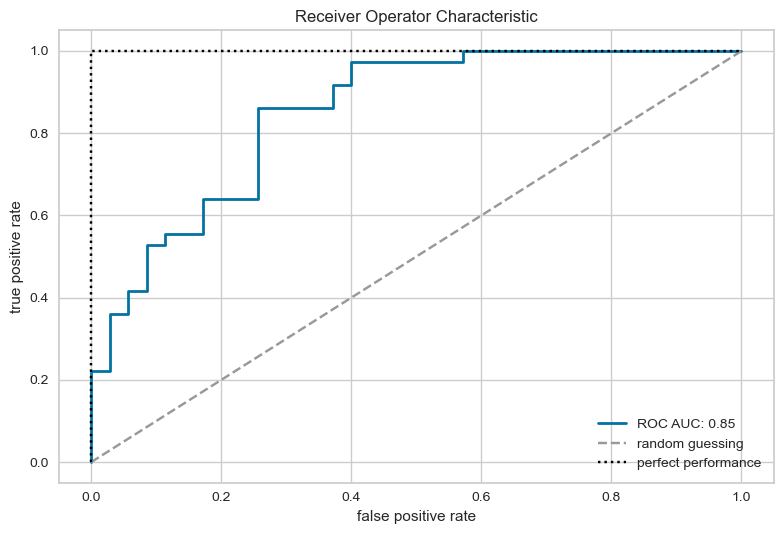

In [24]:
roc_auc(y_test, search.best_estimator_.predict_proba(X_test_redu)[:,1])

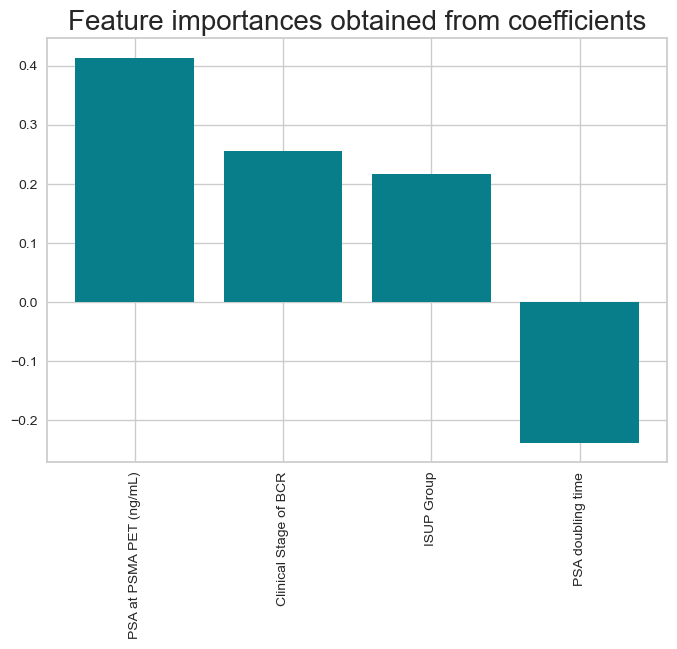

In [25]:
importances = pd.DataFrame(data={
    'Attribute': X_learning_redu.columns,
    'Importance': search.best_estimator_.coef_[0]
})
importances = importances.sort_values(by='Importance', ascending=False)

plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
plt.title('Feature importances obtained from coefficients', size=20)
plt.xticks(rotation='vertical')
plt.show()

In [26]:
importances.reset_index().drop(columns='index').round(decimals = 2)

,Attribute,Importance
0,PSA at PSMA PET (ng/mL),0.41
1,Clinical Stage of BCR,0.25
2,ISUP Group,0.22
3,PSA doubling time,-0.24


In [27]:
# Finding the best probability threshold to have the best accuracy

Find_Optimal_Cutoff(y_test,search.best_estimator_.predict_proba(X_test_redu)[:,1])

     Cut_Off  Accuracy
526     52.6  0.802817
527     52.7  0.802817
528     52.8  0.802817
529     52.9  0.802817
530     53.0  0.802817
531     53.1  0.802817


<h2 style="
              color:black;">Logistic Regression - Nomogram Features</h2>

In [28]:
# Train - Test splitting

X_learning, X_test, _, _ = Kolomogorov_Smirnov_splitting(df[nomogram_features], 1000, 'PET RESULT', 0.1)

In [29]:
# Finding optimal Cross Validation folds number

for ncv in range(2,11,1):
    lr = LogisticRegression(random_state = 123)

    parameters = {'C':np.arange(0.01,1,0.01),  
                  'solver':('liblinear', 'lbfgs',  'newton-cg', 'newton-cholesky', 'sag', 'saga')}

    search = GridSearchCV(lr, parameters, cv = ncv, scoring="roc_auc",verbose=0)

    search.fit(X_learning,y_learning)
    
    print(f'CV folds: {ncv} | {search.best_params_} | LogLoss: {log_loss(y_test, search.best_estimator_.predict_proba(X_test))} | AUC: {roc_auc_score(y_test, search.best_estimator_.predict_proba(X_test)[:,1])} ')

CV folds: 2 | {'C': 0.01, 'solver': 'saga'} | LogLoss: 0.49047435030584974 | AUC: 0.8428571428571429 
CV folds: 3 | {'C': 0.03, 'solver': 'sag'} | LogLoss: 0.48007564010113285 | AUC: 0.8460317460317461 
CV folds: 4 | {'C': 0.03, 'solver': 'sag'} | LogLoss: 0.48007564010113285 | AUC: 0.8460317460317461 
CV folds: 5 | {'C': 0.02, 'solver': 'saga'} | LogLoss: 0.482933974210309 | AUC: 0.8484126984126984 
CV folds: 6 | {'C': 0.02, 'solver': 'sag'} | LogLoss: 0.48318193557726574 | AUC: 0.8436507936507937 
CV folds: 7 | {'C': 0.02, 'solver': 'lbfgs'} | LogLoss: 0.4834900567348031 | AUC: 0.8404761904761905 
CV folds: 8 | {'C': 0.04, 'solver': 'sag'} | LogLoss: 0.47834414113111323 | AUC: 0.8507936507936509 
CV folds: 9 | {'C': 0.04, 'solver': 'saga'} | LogLoss: 0.4781789081185557 | AUC: 0.8492063492063492 
CV folds: 10 | {'C': 0.01, 'solver': 'saga'} | LogLoss: 0.49047435030584974 | AUC: 0.8428571428571429 


In [30]:
# Retrain the model setting optimal folds number

lr = LogisticRegression(random_state = 123)

ncv = 8

parameters = {'C':np.arange(0.01,1,0.01),  
              'solver':('liblinear', 'lbfgs',  'newton-cg', 'newton-cholesky', 'sag', 'saga')}

search = GridSearchCV(lr, parameters, cv = ncv, scoring="roc_auc",verbose=0)

search.fit(X_learning,y_learning)

lr_model = search.best_estimator_

dump(lr_model, 'lr_model.sav')

print(f'CV folds: {ncv} | {search.best_params_} | LogLoss: {log_loss(y_test, lr_model.predict_proba(X_test))} | AUC: {roc_auc_score(y_test, lr_model.predict_proba(X_test)[:,1])} ')

CV folds: 8 | {'C': 0.04, 'solver': 'sag'} | LogLoss: 0.47834414113111323 | AUC: 0.8507936507936509 


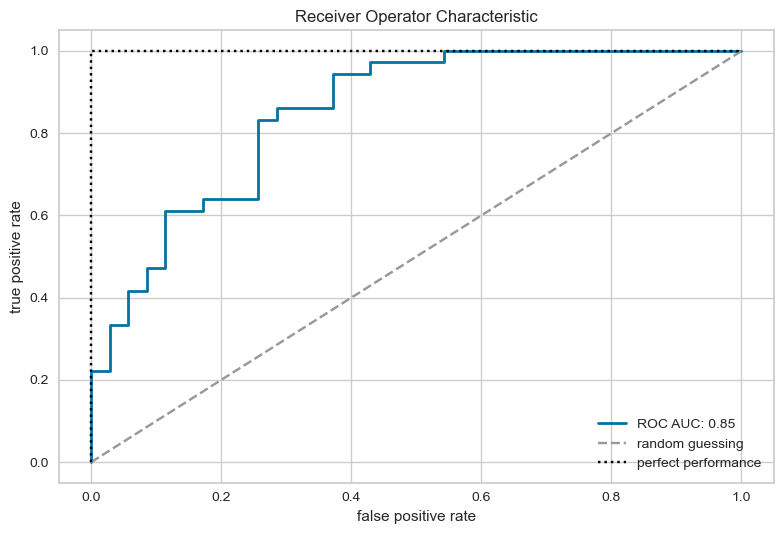

In [31]:
roc_auc(y_test, lr_model.predict_proba(X_test)[:,1])

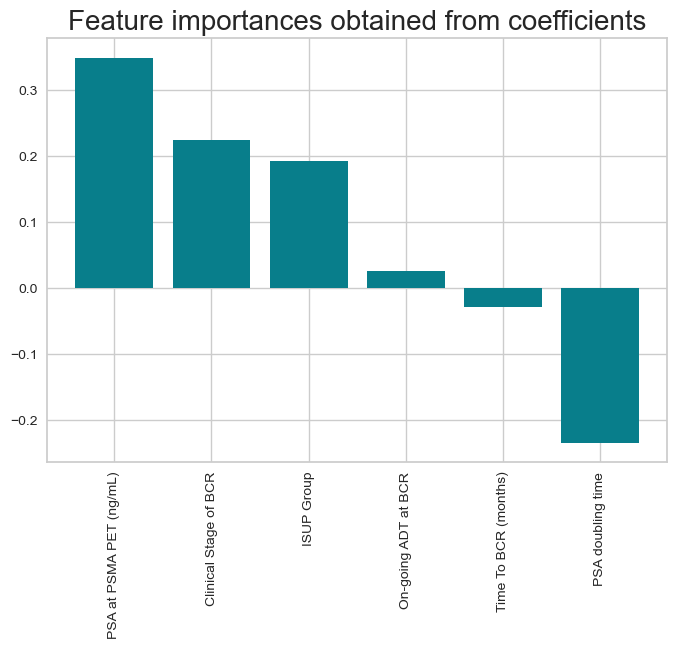

In [32]:
importances = pd.DataFrame(data={
    'Attribute': X_learning.columns,
    'Importance': lr_model.coef_[0]
})
importances = importances.sort_values(by='Importance', ascending=False)

plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
plt.title('Feature importances obtained from coefficients', size=20)
plt.xticks(rotation='vertical')
plt.show()

In [33]:
importances.reset_index().drop(columns='index').round(decimals = 2)

,Attribute,Importance
0,PSA at PSMA PET (ng/mL),0.35
1,Clinical Stage of BCR,0.22
2,ISUP Group,0.19
3,On-going ADT at BCR,0.03
4,Time To BCR (months),-0.03
5,PSA doubling time,-0.23


In [34]:
# Finding the best probability threshold to have the best accuracy

Find_Optimal_Cutoff(y_test,lr_model.predict_proba(X_test)[:,1])

     Cut_Off  Accuracy
523     52.3  0.788732
524     52.4  0.788732
525     52.5  0.788732
526     52.6  0.788732
527     52.7  0.788732
528     52.8  0.788732
529     52.9  0.788732
530     53.0  0.788732
531     53.1  0.788732
532     53.2  0.788732
533     53.3  0.788732
534     53.4  0.788732
535     53.5  0.788732
536     53.6  0.788732
537     53.7  0.788732
538     53.8  0.788732


<h2 style="
              color:black;">Nomogram Baseline</h2>

In [35]:
nomogram = df[['NG','NG Prob PET 1']]
nomogram_test = nomogram.filter(items = X_test.index, axis=0)
nomogram_train = nomogram.filter(items = X_learning.index, axis=0)

In [36]:
print('AUC complete dataset: ', roc_auc_score(df['PET RESULT'], nomogram['NG Prob PET 1']))
print('AUC training dataset: ', roc_auc_score(y_learning, nomogram_train['NG Prob PET 1']))
print('AUC external dataset: ', roc_auc_score(y_test, nomogram_test['NG Prob PET 1']))

AUC complete dataset:  0.8206430191124068
AUC training dataset:  0.8195496632996633
AUC external dataset:  0.8277777777777778


In [37]:
# Finding the best probability threshold to have the best accuracy

Find_Optimal_Cutoff(y_test, nomogram_test['NG Prob PET 1'])

      Cut_Off  Accuracy
461      46.1  0.666667
462      46.2  0.666667
463      46.3  0.666667
464      46.4  0.666667
465      46.5  0.666667
...       ...       ...
996      99.6  0.666667
997      99.7  0.666667
998      99.8  0.666667
999      99.9  0.666667
1000    100.0  0.666667

[540 rows x 2 columns]


In [38]:
nomogram_test['y'] = y_test

cutoff = []
acc = []

for co in np.arange(0, 100.1, 0.1):

    TP = nomogram_test[(nomogram_test['NG Prob PET 1']>=co/100)&(nomogram_test.y==1)].index.size
    FP = nomogram_test[(nomogram_test['NG Prob PET 1']>=co/100)&(nomogram_test.y==0)].index.size
    TN = nomogram_test[(nomogram_test['NG Prob PET 1']< co/100)&(nomogram_test.y==0)].index.size
    FN = nomogram_test[(nomogram_test['NG Prob PET 1']< co/100)&(nomogram_test.y==1)].index.size

    cutoff.append(co)
    acc.append((TN + TP)/(TN+TP+FN+FP))

cut_off = pd.DataFrame(cutoff, columns=['Cut_Off'])
cut_off['Accuracy'] = acc

print(cut_off[cut_off['Accuracy'] == max(cut_off['Accuracy'])])
    

     Cut_Off  Accuracy
371     37.1  0.760563
372     37.2  0.760563
373     37.3  0.760563
374     37.4  0.760563
375     37.5  0.760563
376     37.6  0.760563
377     37.7  0.760563
378     37.8  0.760563
379     37.9  0.760563
380     38.0  0.760563
381     38.1  0.760563
382     38.2  0.760563
383     38.3  0.760563
384     38.4  0.760563
385     38.5  0.760563
386     38.6  0.760563
387     38.7  0.760563
388     38.8  0.760563
389     38.9  0.760563
390     39.0  0.760563
391     39.1  0.760563
392     39.2  0.760563
393     39.3  0.760563
394     39.4  0.760563
395     39.5  0.760563
396     39.6  0.760563
397     39.7  0.760563
398     39.8  0.760563
399     39.9  0.760563
400     40.0  0.760563


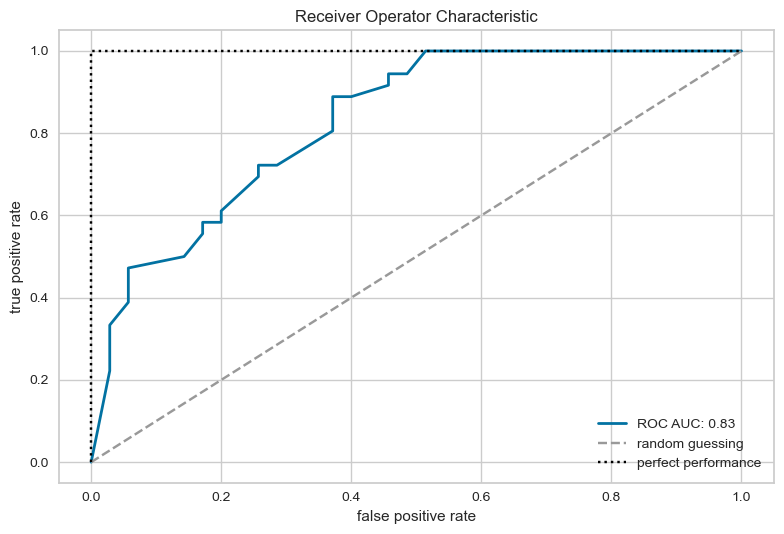

In [39]:
roc_auc(y_test, nomogram_test['NG Prob PET 1'])

In [40]:
roc_auc_score(y_test, nomogram_test['NG Prob PET 1'])

0.8277777777777778

<h2 style="
              color:black;">ROC Curves comparison</h2>

In [41]:
lr_model_preds = lr_model.predict_proba(X_test)[:,1]
lr_model_redu_preds = lr_reduced_model.predict_proba(X_test_redu)[:,1]

ROCS = pd.DataFrame({'nomogram_pred':nomogram_test['NG Prob PET 1'], 'lr_pred': lr_model_preds, 'lr_redu': lr_model_redu_preds})

roc = pyroc.ROC(y_test, ROCS)

In [42]:
# Comparison nonomgram ROC curve vs Logistic Regression ROC curve

p, ci = roc.compare(np.array([
    [1, -1, 0],
]))
print(p, ci)
print('p-value > 0.05 --> no statistical difference between the curves')

0.33456433515537753 [[-0.06976417  0.02373242]]
p-value > 0.05 --> no statistical difference between the curves


In [43]:
# Comparison nonomgram ROC curve vs Reduced Logistic Regression ROC curve

p, ci = roc.compare(np.array([
    [1, 0, -1],
]))
print(p, ci)
print('p-value > 0.05 --> no statistical difference between the curves')

0.3437358903902892 [[-0.06822383  0.02377938]]
p-value > 0.05 --> no statistical difference between the curves


Text(0.5, 1.0, 'Models ROC Curves comparison')

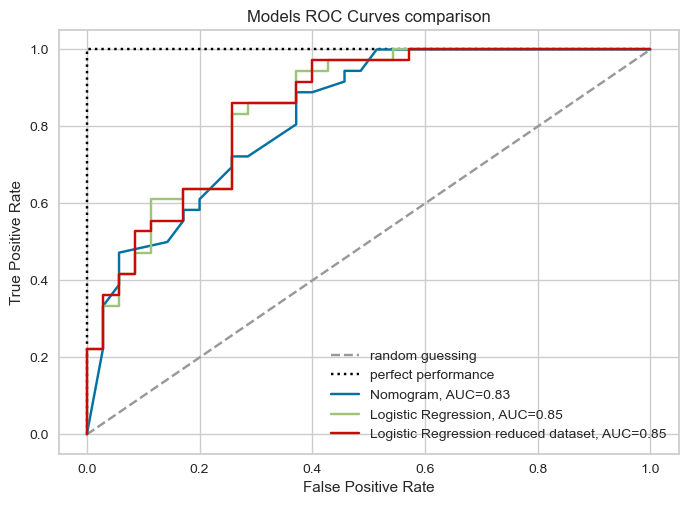

In [44]:
#set up plotting area
plt.figure(0).clf()

plt.plot([0, 1], [0, 1],
         linestyle = '--',
         color = (0.6, 0.6, 0.6),
         label = 'random guessing')
plt.plot([0, 0, 1], [0, 1, 1],
         linestyle = ':',
         color = 'black', 
         label = 'perfect performance')

#nomogram plot ROC curve
fpr, tpr, _ = roc_curve(y_test, nomogram_test['NG Prob PET 1'])
auc = round(roc_auc_score(y_test, nomogram_test['NG Prob PET 1']), 2)
plt.plot(fpr,tpr,label="Nomogram, AUC="+str(auc))

#logistic regression model plot ROC curve
fpr, tpr, _ = roc_curve(y_test, lr_model_preds)
auc = round(roc_auc_score(y_test, lr_model_preds), 2)
plt.plot(fpr,tpr,label="Logistic Regression, AUC="+str(auc))

#logistic regression model reduced dataset plot ROC curve
fpr, tpr, _ = roc_curve(y_test, lr_model_redu_preds)
auc = round(roc_auc_score(y_test, lr_model_redu_preds), 2)
plt.plot(fpr,tpr,label="Logistic Regression reduced dataset, AUC="+str(auc))



#add legend
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Models ROC Curves comparison')

<h2 style="
              color:black;">Tables Creation</h2>

In [45]:
def ttest(x):
    pvalue = ttest_ind(X_learning[x], X_test[x])[1]
    return round(pvalue, 2)

LEARNING = X_learning.copy()
TEST = X_test.copy()

LEARNING['PET RESULT'] = y_learning
TEST['PET RESULT'] = y_test

LEARNING['Clinical Stage of BCR'].replace({0:'First recurrence after primary treatment',
                                           1:'Recurrence after salvage therapy',
                                           2:'PSA persistence after primary treatment',
                                           3:'PSA progression before systemic therapies'}, inplace=True)
LEARNING['ISUP Group'].replace({0:1, 1:2, 2:3, 3:4, 4:5}, inplace=True)
LEARNING['On-going ADT at BCR'].replace({0:'No', 1:'Yes'}, inplace=True)
LEARNING['Time To BCR (months)'].replace({0:'>12', 1:'≤12'}, inplace=True)
LEARNING['PET RESULT'].replace({0:'Negative', 1:'Positive'}, inplace=True)

TEST['Clinical Stage of BCR'].replace({0:'First recurrence after primary treatment',
                                           1:'Recurrence after salvage therapy',
                                           2:'PSA persistence after primary treatment',
                                           3:'PSA progression before systemic therapies'}, inplace=True)
TEST['ISUP Group'].replace({0:1, 1:2, 2:3, 3:4, 4:5}, inplace=True)
TEST['On-going ADT at BCR'].replace({0:'No', 1:'Yes'}, inplace=True)
TEST['Time To BCR (months)'].replace({0:'>12', 1:'≤12'}, inplace=True)
TEST['PET RESULT'].replace({0:'Negative', 1:'Positive'}, inplace=True)

one_hotted_learning = pd.concat([
    LEARNING[['PSA at PSMA PET (ng/mL)','PSA doubling time']], 
    pd.get_dummies(LEARNING['ISUP Group'], prefix='ISUP Group'), 
    pd.get_dummies(LEARNING['Clinical Stage of BCR'], prefix='Clinical Stage of BCR'),
    pd.get_dummies(LEARNING['On-going ADT at BCR'], prefix='On-going ADT at BCR'),
    pd.get_dummies(LEARNING['Time To BCR (months)'], prefix='Time To BCR (months)'),
    pd.get_dummies(LEARNING['PET RESULT'], prefix='PET RESULT')],
    axis = 1)

one_hotted_test = pd.concat([
    TEST[['PSA at PSMA PET (ng/mL)','PSA doubling time']], 
    pd.get_dummies(TEST['ISUP Group'], prefix='ISUP Group'), 
    pd.get_dummies(TEST['Clinical Stage of BCR'], prefix='Clinical Stage of BCR'),
    pd.get_dummies(TEST['On-going ADT at BCR'], prefix='On-going ADT at BCR'),
    pd.get_dummies(TEST['Time To BCR (months)'], prefix='Time To BCR (months)'),
    pd.get_dummies(TEST['PET RESULT'], prefix='PET RESULT')],
    axis = 1)

desc_ooh_learning = one_hotted_learning.describe().T
desc_ooh_learning['Features'] = desc_ooh_learning.index
desc_ooh_learning['Training Set'] = desc_ooh_learning.Features.apply(lambda x: f'{sum(one_hotted_learning[x])}({round(sum(one_hotted_learning[x])*100/632, 2)})')
desc_ooh_learning['External Validation Set'] = desc_ooh_learning.Features.apply(lambda x: f'{sum(one_hotted_test[x])}({round(sum(one_hotted_test[x])*100/71, 2)})')
desc_ooh_learning['Training Set']['PSA at PSMA PET (ng/mL)'] = f'{1.34}({0.39}-{1.34})'
desc_ooh_learning['Training Set']['PSA doubling time'] = f'{8.13}({3.50}-{9.73})'
desc_ooh_learning['External Validation Set']['PSA at PSMA PET (ng/mL)'] = f'{1.30}({0.38}-{1.24})'
desc_ooh_learning['External Validation Set']['PSA doubling time'] = f'{6.95}({4.00}-{9.15})'

empties = pd.DataFrame(index = ['ISUP Group','Clinical Stage of BCR', 'On-going ADT at BCR', 'Time To BCR (months)', 'PET RESULT' ], columns=['Training Set', 'External Validation Set'])

pvalue = []

for feat in empties.index[:-1]:
    pvalue.append(ttest(feat))
    
pvalue.append(round(ttest_ind(y_learning, y_test)[1],2))

empties['p-value'] = pvalue

desc_ooh = pd.concat([desc_ooh_learning[['Training Set', 'External Validation Set']], empties])

desc_ooh['features'] = desc_ooh.index
desc_ooh['features'] = desc_ooh['features'].apply(lambda x: x.split('_')[-1])
desc_ooh.index = desc_ooh['features']
desc_ooh.index.name = None

desc_ooh = desc_ooh.reindex(['ISUP Group', '1', '2', '3','4','5',
                 'PSA at PSMA PET (ng/mL)', 'PSA doubling time',
                 'On-going ADT at BCR', 'No', 'Yes',
                 'Time To BCR (months)', '>12', '≤12',
                 'Clinical Stage of BCR', 'First recurrence after primary treatment', 'Recurrence after salvage therapy' ,'PSA persistence after primary treatment', 'PSA progression before systemic therapies',
                 'PET RESULT', 'Negative', 'Positive'])

desc_ooh = desc_ooh[['Training Set', 'External Validation Set', 'p-value']]
desc_ooh.replace({np.nan:''}, inplace=True)
desc_ooh['p-value']['PSA doubling time'] = round(ttest_ind(LEARNING['PSA doubling time'], TEST['PSA doubling time'])[1],2)
desc_ooh['p-value']['PSA at PSMA PET (ng/mL)'] = round(ttest_ind(LEARNING['PSA at PSMA PET (ng/mL)'], TEST['PSA at PSMA PET (ng/mL)'])[1],2)
desc_ooh

,Training Set,External Validation Set,p-value
ISUP Group,,,0.74
1,60(9.49),7(9.86),
2,130(20.57),13(18.31),
3,202(31.96),21(29.58),
4,205(32.44),27(38.03),
5,35(5.54),3(4.23),
PSA at PSMA PET (ng/mL),1.34(0.39-1.34),1.3(0.38-1.24),0.94
PSA doubling time,8.13(3.5-9.73),6.95(4.0-9.15),0.21
On-going ADT at BCR,,,0.92
No,528(83.54),59(83.1),


In [46]:
ROCS_bin = ROCS.copy()
ROCS_bin['nomogram_pred'] = ROCS_bin['nomogram_pred'].apply(lambda x: 1 if x>= 0.4 else 0)
ROCS_bin['lr_pred'] = ROCS_bin['lr_pred'].apply(lambda x: 1 if x>= 0.53 else 0)
ROCS_bin['lr_redu'] = ROCS_bin['lr_redu'].apply(lambda x: 1 if x>= 0.53 else 0)
ROCS_bin['y'] = y_test

recap_table = pd.DataFrame(index = ['True Positive', 
                                    'False Positive',
                                    'True Negative',
                                    'False Negative',
                                    'AUC',
                                    'Accuracy (cut-off)',
                                    'DeLong Value'],
                          columns= ['Nomogram',
                                   'Logistic Regression',
                                   'Logistic Regression reduced dataset'])

ngcm = confusion_matrix(y_test, ROCS_bin['nomogram_pred'])
ng = [ngcm[1][1], ngcm[0][1], ngcm[0][0], ngcm[1][0], '0.82 95%CI(0.79-0.85)', '76.00% (40.00%)', ' ']

lrcm = confusion_matrix(y_test, ROCS_bin['lr_pred'])
lr = [lrcm[1][1], lrcm[0][1], lrcm[0][0], lrcm[1][0], "0.85 95%CI(0.77-0.93)", '78.87% (53.00%)', '0.33']

lrrcm = confusion_matrix(y_test, ROCS_bin['lr_redu'])
lrr = [lrrcm[1][1], lrrcm[0][1], lrrcm[0][0], lrrcm[1][0], '0.85 95%CI(0.77-0.93)', '80.28% (53.00%)', '0.34']

recap_table['Nomogram'] = ng
recap_table['Logistic Regression'] = lr
recap_table['Logistic Regression reduced dataset']=lrr

recap_table


,Nomogram,Logistic Regression,Logistic Regression reduced dataset
True Positive,32,31,31
False Positive,13,10,9
True Negative,22,25,26
False Negative,4,5,5
AUC,0.82 95%CI(0.79-0.85),0.85 95%CI(0.77-0.93),0.85 95%CI(0.77-0.93)
Accuracy (cut-off),76.00% (40.00%),78.87% (53.00%),80.28% (53.00%)
DeLong Value,,0.33,0.34


<h2 style="
              color:black;">Conclusions</h2>
              
The Logistic Regression model demonstrated superior performance among the tested machine learning algorithms. While it did not significantly outperform the previously published nomogram in predicting PSMA positivity in prostate cancer patients, these findings imply that machine learning methods have potential value as complementary tools for implementation and comparison alongside established methodologies in the medical field. This holds particular relevance in the context of developing explainable AI for future routine clinical applications of these emerging technologies.